# WASP-80b broadband analysis 
## 6. Publication plots and values
**Hannu Parviainen, Instituto de Astrofísica de Canarias**<br>

---

This notebook works as an appendix to Parviainen et al., *Ground based transmission spectroscopy of WASP-80b* (2017). The paper covers two analyses: a broadband analysis using three previously published datasets, and a transmission spectroscopy analysis using two GTC-observed spectroscopic time series, and this notebook covers a part of the broadband analysis.

**Last (significant) revision: 14.08.2017**

---

In [1]:
%pylab inline
%run __init__.py

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sb
from src.core import *
from src.extcore import *
from src.lpf import *

from scipy.stats import gaussian_kde as gkde
import astropy.time as at

In [3]:
sb.set_context('paper')
sb.set_style('white')

In [4]:
from src.w80plots import wavelength_to_rgb
dff = pd.read_hdf(DFILE_EXT, 'transmission')
wl = dff.index.values
passbands = 'g r i z J H K'.split()
pb_centers = array([average(wl, weights=dff[c].values) for c in dff.columns])
pbb = sb.color_palette(wavelength_to_rgb(clip(400 + 0.35*(pb_centers-pb_centers.min()), 370, 700)))

In [5]:
def create_dataframe(df, lpf, burn=100, return_chains=False):
    ch = df.values.reshape([150,-1,lpf.ndim])
    fc = ch[:,burn:,:].reshape([-1,lpf.ndim])
    df = pd.DataFrame(fc, columns=lpf.ps.names)
    
    k2cols = [c for c in df.columns if 'k2' in c]
    kcols = [c.replace('k2', 'k') for c in k2cols]
    for ca,ck in zip(k2cols,kcols):
        df[ck] = sqrt(df[ca])
        
    q1cols = [c for c in df.columns if 'q1_' in c]
    q2cols = [c for c in df.columns if 'q2_' in c]
    ucols = [c.replace('q1', 'u') for c in q1cols]
    vcols = [c.replace('q2', 'v') for c in q2cols]

    for q1,q2,u,v in zip(q1cols,q2cols,ucols,vcols):
        a,b = sqrt(df[q1]), 2*df[q2]
        df[u] = a*b
        df[v] = a*(1-b)
        
    df['tc_mjd'] = at.Time(df.tc + TZERO, format='jd').mjd
    df['tc_centred'] = df.tc_mjd - floor(df.tc_mjd.mean())
    if not return_chains:
        return df
    else:
        return df, ch

def plot_violin1(a, ax, c=0, w=0.5, color=None, ylabel=''):
    xmin, xmax = a.min(), a.max()
    x = linspace(xmin, xmax, num=100)
    
    ppars = {'linewidth':0, 'edgecolor':'k'}
    if color:
        ppars['color'] = color
    
    for s in [-1,1]:
        xin = linspace(*percentile(a, [16,84]))
        gk = gkde(a, w)
        vl1 = gk(x)
        vl2 = gk(xin)
        vl2 /= 2.4 * vl1.max()
        vl1 /= 2.4 * vl1.max()
        ax.fill_betweenx(x, c+s*vl1, c, alpha=0.4, **ppars)
        ax.fill_betweenx(xin, c+s*vl2, c, color='k', alpha=0.25, linewidth=0)
        ax.plot(c+s*vl1, x, 'k', lw=0.5)
    ax.plot([c-vl2[0], c+vl2[0]], xin[[0,0]], 'k', lw=0.5)
    ax.plot([c-vl2[-1], c+vl2[-1]], xin[[-1,-1]], 'k', lw=0.5)
    
def plot_violin(a1, a2, ax, c=0, w=0.5, color=None, ylabel='', slabels=['',''], offset=0.02):
    xmin = min(a1.min(), a2.min())
    xmax = max(a1.max(), a2.max())
    x = linspace(xmin, xmax, num=100)
    
    ppars = {'linewidth':0, 'edgecolor':'k'}
    if color:
        ppars['color'] = color
    
    for s,a,os,alpha in zip([-1,1],[a1,a2],[-offset,offset],[0.4,0.3]):
        xin = linspace(*percentile(a, [16,84]))
        gk = gkde(a, w)
        vl1 = gk(x)
        vl2 = gk(xin)
        vl2 /= 2.4 * vl1.max()
        vl1 /= 2.4 * vl1.max()
        ax.fill_betweenx(x, c+s*vl1+os, c+os, alpha=alpha, **ppars)
        ax.fill_betweenx(xin, c+s*vl2+os, c+os, color='k', alpha=0.25, linewidth=1)
        ax.plot(c+s*vl1+os, x, 'k', lw=0.5)
        ax.plot([c+os,c+os], [xmin,xmax], 'k', lw=0.5)
        ax.plot([c-os,c-os], [xmin,xmax], 'k', lw=0.5)
        ax.plot([c+os, c+s*vl2[0]+os], xin[[0,0]], 'k', lw=0.5)
        ax.plot([c+os, c+s*vl2[-1]+os], xin[[-1,-1]], 'k', lw=0.5)
        if s < 0:
            ax.text(vl1[-1]+os-0.07, xmax, slabels[0], ha='right', va='top')
        else:
            ax.text(vl1[-1]+os+0.07, xmax, slabels[1], ha='left', va='top')

    #ax.plot([c,c], [xmin,xmax], 'k', lw=0.5)  
    
    setp(ax, ylabel=ylabel)

In [244]:
lpfr = LPFRN(constant_k=True)
rl = create_dataframe(pd.read_hdf(RFILE_EXT, 'ckrn_ldtk/fc'), lpfr)
rf = create_dataframe(pd.read_hdf(RFILE_EXT, 'ckrn/fc'), lpfr)
rl['tc_hjd'] = rl.tc + TZERO

In [212]:
scols = 'tc_hjd p b rho k_w'.split()
pe = percentile(rl[scols], [50,16,84], 0)
print(' & '.join(map(str, pe[0])) + r'\\')
print(' & '.join(map(lambda v:'({})'.format(v), abs(pe[1:]-pe[0]).mean(0)))  + r'\\')


2456125.41759 & 3.06785955853 & 0.214510532647 & 4.09064081221 & 0.171459118846\\
(9.270175360143185e-05) & (8.563741840106331e-07) & (0.020577933050132904) & (0.054892253406865876) & (0.0003188394215230539)\\


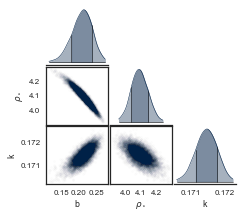

In [326]:
fig,axs = subplots(3,3, figsize=(AAOCW, 0.9*AAOCW))
pcols = scols[2:]

for ic,c in enumerate(pcols):
    ax = axs[ic,ic]
    x1 = linspace(*percentile(rl[c], [0.5,99.5]))
    x2 = linspace(*percentile(rl[c], [16,84]))
    gk = gkde(rl[c], 0.2)
    ax.fill_between(x1, gk(x1), alpha=0.35, color=c_ob)
    ax.fill_between(x2, gk(x2), color=c_ob, alpha=0.25, linewidth=0.5)
    ax.plot(x1, gk(x1), c=c_ob, lw=0.5)
    ax.plot(x2[[0,0]], [0,gk(x2)[0]], 'k', lw=0.5)
    ax.plot(x2[[-1,-1]], [0,gk(x2)[-1]], 'k', lw=0.5)
    ax.plot(x1[[0,-1]], [0,0], 'k', lw=0.5)

    setp(ax, yticks=[], )
    if ic!=2:
        setp(ax.get_xticklabels(), visible=False)
    sb.despine(ax=ax, left=True)
    
for ix,c1 in enumerate(pcols[:-1]):
    for iy,c2 in enumerate(pcols[1:]):
        ax = axs[iy+1,ix]
        if ix<=iy:
            ax.plot(rl[c1],rl[c2], '.', alpha=0.01)
        if ix>0:
            setp(ax.get_yticklabels(), visible=False)
        if iy<1:
            setp(ax.get_xticklabels()+[ax.get_xaxis().get_offset_text()], visible=False)
        if ix>iy+1:
            setp(ax, visible=False)
        setp(axs[0,1:], visible=False)
        setp(axs[1,-1], visible=False)
        
[setp(ax, ylabel=l) for ax,l in zip(axs[1:,0], r'$\rho_\star$, k'.split(', '))]
[setp(ax, xlabel=l) for ax,l in zip(axs[-1,:], r'b, $\rho_\star$, k'.split(', '))]
setp(axs[:,1], xlim=(3.9,4.3))
setp(axs[1,0], ylim=(3.9,4.3))
setp(axs[2,1], xticks=[4.0, 4.1, 4.2])
setp(axs[1,0], yticks=[4.0, 4.1, 4.2])
fig.tight_layout()
fig.subplots_adjust(hspace=0.03, wspace=0.03)
fig.savefig('../../plots/pub_ext_correlations.pdf')

## Plot the distributions

### Radius ratios for the vkrn run

In [194]:
lpfr = LPFRN(constant_k=False)
rl = create_dataframe(pd.read_hdf(RFILE_EXT, 'vkrn_ldtk/fc'), lpfr)
k2c = [c for c in fcv.columns if 'k2_' in c]
kc  = [c.replace('2_','_') for c in k2c]

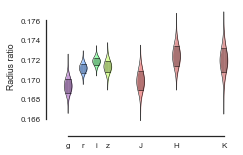

In [208]:
fig,ax = subplots(figsize=(AAOCW,0.65*AAOCW), sharey=True)
pbc = (pb_centers-pb_centers[0])/100
for i,c in enumerate(kc):
    plot_violin1(rl[c], ax=ax, c=pbc[i], color=pbb[i])
setp(ax, ylabel='Radius ratio', xticks=pbc, xticklabels=passbands)
sb.despine(fig, offset=10, trim=True)
fig.tight_layout()
#fig.savefig('../../plots/pub_ext_vk.pdf')

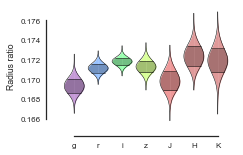

In [209]:
fig,ax = subplots(figsize=(AAOCW,0.65*AAOCW), sharey=True)
for i,c in enumerate(kc):
    plot_violin1(rl[c], ax=ax, c=i, color=pbb[i])
setp(ax, ylabel='Radius ratio', xticks=arange(len(passbands)), xticklabels=passbands)
sb.despine(fig, offset=10, trim=True)
fig.tight_layout()
fig.savefig('../../plots/pub_ext_vk.pdf')

In [178]:
kp = percentile(rl[kc], [50,16,84], 0)
print(' & '.join(map(str, kp[0].round(5))) + r'\\')
print(' & '.join(map(lambda v:'({:7.5f})'.format(v), abs(kp[1:]-kp[0]).mean(0).round(5)))  + r'\\')

0.16936 & 0.17115 & 0.17185 & 0.17131 & 0.16985 & 0.17238 & 0.17195\\
(0.00071) & (0.00045) & (0.00038) & (0.00060) & (0.00097) & (0.00103) & (0.00120)\\


### Limb darkening coefficients for the ckrn run

In [6]:
lpfr = LPFRN(constant_k=True)
rf = create_dataframe(pd.read_hdf(RFILE_EXT, 'ckrn/fc'),      lpfr) # red noise, free ld
rl = create_dataframe(pd.read_hdf(RFILE_EXT, 'ckrn_ldtk/fc'), lpfr) # red noise, with LDTk

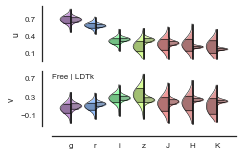

In [7]:
ucols = [c.replace('q1', 'u') for c in rf.columns if 'q1' in c]
vcols = [c.replace('q2', 'v') for c in rf.columns if 'q2' in c]

fig,ax = subplots(2,1, figsize=(AAOCW,0.65*AAOCW))
for i,(u,v) in enumerate(zip(ucols,vcols)):
    plot_violin(rf[u], rl[u], ax=ax[0], c=i, color=pbb[i], ylabel='u')
    plot_violin(rf[v], rl[v], ax=ax[1], c=i, color=pbb[i], ylabel='v')
ax[1].text(0.1, 0.7, 'Free | LDTk', ha='center', size=8)
sb.despine(ax=ax[0], bottom=True, offset=10)
sb.despine(ax=ax[1], offset=10)
setp(ax[0], xticks=[], yticks=[0.1, 0.4, 0.7])
setp(ax[1], xticks=arange(len(passbands)), xticklabels=passbands, yticks=[-0.1, 0.3, 0.7])
fig.tight_layout()
#fig.savefig('../../plots/pub_ext_ldcs.pdf')

In [12]:
ldcols = [c.replace('u_','uv_') for c in ucols]

In [18]:
for ldc,uc,vc in zip(ldcols,ucols,vcols):
    rf[ldc] = rf[uc].values+rf[vc].values
    rl[ldc] = rl[uc].values+rl[vc].values

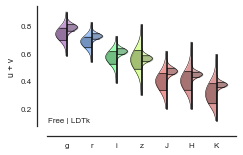

In [27]:
fig,ax = subplots(figsize=(AAOCW,0.65*AAOCW))
for i,c in enumerate(ldcols):
    plot_violin(rf[c], rl[c], ax=ax, c=i, color=pbb[i], ylabel='u + v')
ax.text(0.1, 0.1, 'Free | LDTk', ha='center', size=8)
sb.despine(ax=ax, offset=10)
setp(ax, xticks=arange(len(passbands)), xticklabels=passbands)
fig.tight_layout()

In [142]:
lc_names = concatenate([lp.hps.lc_name.values for lp in lpf.lpfs])

In [143]:
lc_dsnames = [n.strip('/')[0].upper() for n in lc_names]

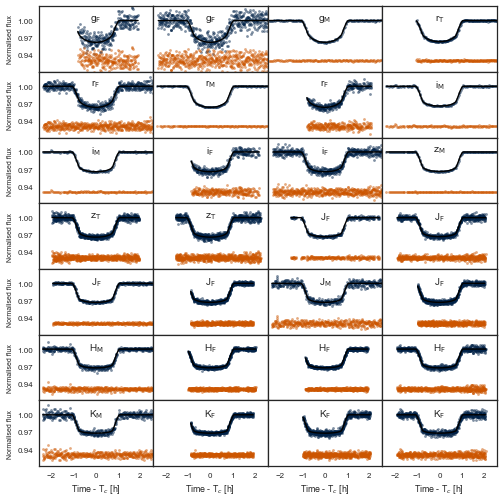

In [144]:
phases = [(fold(t, P, TC, 0.5) - 0.5)*24*P for t in lpf.times]
fluxes_m, residuals, gpmeans = [], [], []

for l in lpf.lpfs:
    fms = l.compute_lc_model(mp)
    res = [fo-fm for fo,fm in zip(l.fluxes, fms)]
    for i,gp in enumerate(l.gps):
        gp.flux = res[i]
        gpmeans.append(gp.predict(None))
    fluxes_m.extend(fms)
    residuals.extend(res)

fig,axs = pl.subplots(7,4, figsize=(AAPGW,AAPGW), sharey=True, sharex=True)
for iax,ilc in enumerate(lpf.lcorder):
    lcid = '{:s}$_\mathrm{{{:s}}}$'.format(lpf.passbands[ilc], lc_dsnames[ilc])
    a = axs.flat[iax]
    a.plot(phases[ilc],lpf.fluxes[ilc]-gpmeans[ilc],'.', alpha=0.5)
    a.plot(phases[ilc],fluxes_m[ilc],'k')
    a.plot(phases[ilc],lpf.fluxes[ilc]-fluxes_m[ilc]-gpmeans[ilc]+0.93,'.', alpha=0.5)
    a.text(0.5, 0.9, lcid, ha='center', va='top', size=10, transform=a.transAxes)
setp(axs, ylim=(0.91,1.025), xlim=(-0.035*24*P, 0.035*24*P))
setp(axs[-1,:], xlabel='Time - T$_c$ [h]', xticks=arange(-2,3))
setp(axs[0,0], ylabel='Normalised flux', yticks=[0.94,0.97,1.0])
[a.set_ylabel('Normalised flux', size=7) for a in axs[:,0]]
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
#fig.savefig('plots/pub_ext_modelled.pdf')

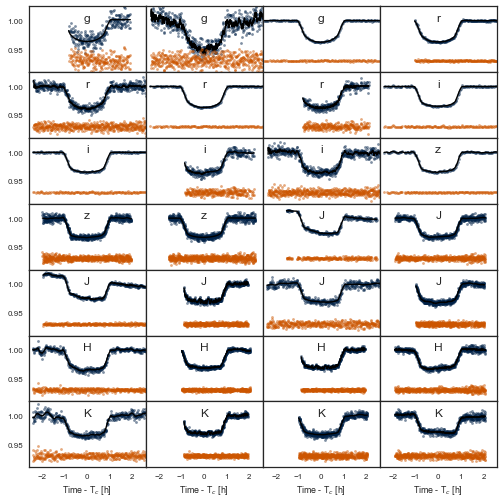

In [145]:
phases = [(fold(t, P, TC, 0.5) - 0.5)*24*P for t in lpf.times]
fluxes_m, residuals, gpmeans = [], [], []

for l in lpf.lpfs:
    fms = l.compute_lc_model(mp)
    res = [fo-fm for fo,fm in zip(l.fluxes, fms)]
    for i,gp in enumerate(l.gps):
        gp.flux = res[i]
        gpmeans.append(gp.predict(None))
    fluxes_m.extend(fms)
    residuals.extend(res)

fig,axs = pl.subplots(7,4, figsize=(AAPGW,AAPGW), sharey=True, sharex=True)
for iax,ilc in enumerate(lpf.lcorder):
    a = axs.flat[iax]
    a.plot(phases[ilc],lpf.fluxes[ilc],'.', alpha=0.5)
    a.plot(phases[ilc],fluxes_m[ilc]+gpmeans[ilc],'k')
    a.plot(phases[ilc],lpf.fluxes[ilc]-fluxes_m[ilc]-gpmeans[ilc]+0.93,'.', alpha=0.5)
    a.text(0.5, 0.9, lpf.passbands[ilc], ha='center', va='top', size=12, transform=a.transAxes)
pl.setp(axs, ylim=(0.91,1.025), xlim=(-0.035*24*P, 0.035*24*P))
pl.setp(axs[-1,:], xlabel='Time - T$_c$ [h]', xticks=arange(-2,3))
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

---

<center> &copy; 2017 <a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a></center>